# Introduction

TBD


In [1]:
epochs = 20
lr_decay = 0
warmup_enabled = True
load_weights = False
train_depth = "all"
batch_size = 32
model_img_size = 448
tta = True
n_classes = 5

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import PIL
from PIL import ImageOps
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras

from tqdm.auto import tqdm
tqdm.pandas()

Using TensorFlow backend.


In [3]:
!ls -l ../input/

total 8
drwxr-xr-x 4 root root 4096 Jun 28 02:06 aptos2019-blindness-detection
drwxr-xr-x 3 root root 4096 Jul  1 02:43 retinopathy-train-2015


## Number of files in train vs test vs the 2015 training set

In [4]:
!ls -l ../input/aptos2019-blindness-detection/train_images | wc -l

3663


In [5]:
!ls -l ../input/aptos2019-blindness-detection/test_images | wc -l

1929


In [6]:
!ls -l ../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896 | wc -l

35127


## Basic metadata

In [7]:
train_path_2015 = "../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/"
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"


In [8]:
df_train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [9]:
df_test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [10]:
df_train_2015 = pd.read_csv("../input/retinopathy-train-2015/rescaled_train_896/trainLabels.csv")
df_train_2015.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Collect all metadata to single dataframe(s)

In [11]:
n_rows = df_train.shape[0]
n_rows

3662

In [12]:
df_train["filename"] = df_train["id_code"]+".png"
df_train["path"] = [train_path]*n_rows
#the year is just to be able to easily separate the past and present datasets later
df_train["year"] = [2019]*n_rows
df_train.head()

,id_code,diagnosis,filename,path,year
0,000c1434d8d7,2,000c1434d8d7.png,../input/aptos2019-blindness-detection/train_i...,2019
1,001639a390f0,4,001639a390f0.png,../input/aptos2019-blindness-detection/train_i...,2019
2,0024cdab0c1e,1,0024cdab0c1e.png,../input/aptos2019-blindness-detection/train_i...,2019
3,002c21358ce6,0,002c21358ce6.png,../input/aptos2019-blindness-detection/train_i...,2019
4,005b95c28852,0,005b95c28852.png,../input/aptos2019-blindness-detection/train_i...,2019


In [13]:
n_rows_2015 = df_train_2015.shape[0]
n_rows_2015

35126

In [14]:
df_train_2015["filename"] = df_train_2015["image"]+".png"
df_train_2015["path"] = [train_path_2015]*n_rows_2015
df_train_2015["year"] = [2015]*n_rows_2015
df_train_2015.head()

,image,level,filename,path,year
0,10_left,0,10_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
1,10_right,0,10_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
2,13_left,0,13_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
3,13_right,0,13_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
4,15_left,1,15_left.png,../input/retinopathy-train-2015/rescaled_train...,2015


In [15]:
n_rows_test = df_test.shape[0]
n_rows_test

1928

In [16]:
df_test["filename"] = df_test["id_code"]+".png"
df_test["path"] = [test_path]*n_rows_test
df_test["year"] = [2050]*n_rows_test
df_test.head()

,id_code,filename,path,year
0,0005cfc8afb6,0005cfc8afb6.png,../input/aptos2019-blindness-detection/test_im...,2050
1,003f0afdcd15,003f0afdcd15.png,../input/aptos2019-blindness-detection/test_im...,2050
2,006efc72b638,006efc72b638.png,../input/aptos2019-blindness-detection/test_im...,2050
3,00836aaacf06,00836aaacf06.png,../input/aptos2019-blindness-detection/test_im...,2050
4,009245722fa4,009245722fa4.png,../input/aptos2019-blindness-detection/test_im...,2050


In [17]:
df_train_2015.columns = ["id_code", "diagnosis", "filename", "path", "year"]
df_train_2015.head()

,id_code,diagnosis,filename,path,year
0,10_left,0,10_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
1,10_right,0,10_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
2,13_left,0,13_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
3,13_right,0,13_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
4,15_left,1,15_left.png,../input/retinopathy-train-2015/rescaled_train...,2015


In [18]:
df_train_all = pd.concat([df_train,df_train_2015, df_test], axis=0, sort=False).reset_index()
df_train_all.head()

,index,id_code,diagnosis,filename,path,year
0,0,000c1434d8d7,2.0,000c1434d8d7.png,../input/aptos2019-blindness-detection/train_i...,2019
1,1,001639a390f0,4.0,001639a390f0.png,../input/aptos2019-blindness-detection/train_i...,2019
2,2,0024cdab0c1e,1.0,0024cdab0c1e.png,../input/aptos2019-blindness-detection/train_i...,2019
3,3,002c21358ce6,0.0,002c21358ce6.png,../input/aptos2019-blindness-detection/train_i...,2019
4,4,005b95c28852,0.0,005b95c28852.png,../input/aptos2019-blindness-detection/train_i...,2019


In [19]:
df_train_all.tail()

,index,id_code,diagnosis,filename,path,year
40711,1923,ff2fd94448de,NaN,ff2fd94448de.png,../input/aptos2019-blindness-detection/test_im...,2050
40712,1924,ff4c945d9b17,NaN,ff4c945d9b17.png,../input/aptos2019-blindness-detection/test_im...,2050
40713,1925,ff64897ac0d8,NaN,ff64897ac0d8.png,../input/aptos2019-blindness-detection/test_im...,2050
40714,1926,ffa73465b705,NaN,ffa73465b705.png,../input/aptos2019-blindness-detection/test_im...,2050
40715,1927,ffdc2152d455,NaN,ffdc2152d455.png,../input/aptos2019-blindness-detection/test_im...,2050


In [20]:
#replacing df_train with the full set to calculate features and do visualizations all at once, keeping the original (present) just in case
df_train_2019 = df_train
df_train = df_train_all

## Calculate Aspect Ratios etc.

In [21]:
%%time
img_sizes = []
widths = []
heights = []
aspect_ratios = []

for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    filename = row["filename"]
    path = row["path"]
    img_path = os.path.join(path, filename)
    with open(img_path, 'rb') as f:
        img = PIL.Image.open(f)
        img_size = img.size
        img_sizes.append(img_size)
        widths.append(img_size[0])
        heights.append(img_size[1])
        aspect_ratios.append(img_size[0]/img_size[1])

df_train["width"] = widths
df_train["height"] = heights
df_train["aspect_ratio"] = aspect_ratios
df_train["size"] = img_sizes


CPU times: user 19.9 s, sys: 14.7 s, total: 34.6 s
Wall time: 2min 26s


In [22]:
df_train.head()

,index,id_code,diagnosis,filename,path,year,width,height,aspect_ratio,size
0,0,000c1434d8d7,2.0,000c1434d8d7.png,../input/aptos2019-blindness-detection/train_i...,2019,3216,2136,1.505618,"(3216, 2136)"
1,1,001639a390f0,4.0,001639a390f0.png,../input/aptos2019-blindness-detection/train_i...,2019,3216,2136,1.505618,"(3216, 2136)"
2,2,0024cdab0c1e,1.0,0024cdab0c1e.png,../input/aptos2019-blindness-detection/train_i...,2019,2416,1736,1.391705,"(2416, 1736)"
3,3,002c21358ce6,0.0,002c21358ce6.png,../input/aptos2019-blindness-detection/train_i...,2019,1050,1050,1.000000,"(1050, 1050)"
4,4,005b95c28852,0.0,005b95c28852.png,../input/aptos2019-blindness-detection/train_i...,2019,2048,1536,1.333333,"(2048, 1536)"


In [23]:
df_train_2019 = df_train[df_train["year"] == 2019]
df_train_2015 = df_train[df_train["year"] == 2015]
df_test = df_train[df_train["year"] == 2050]



In [24]:
#This just shows a single image in the notebook
def show_img(filename, path):
        img = PIL.Image.open(f"{path}/{filename}")
        npa = np.array(img)
        print(npa.shape)
        #https://stackoverflow.com/questions/35902302/discarding-alpha-channel-from-images-stored-as-numpy-arrays
#        npa3 = npa[ :, :, :3]
        print(filename)
        plt.imshow(npa)


In [25]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

## A Random Eye

Visualize the first image in past and present sets to see if they are at all alike:


### Present

(2136, 3216, 3)
000c1434d8d7.png


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


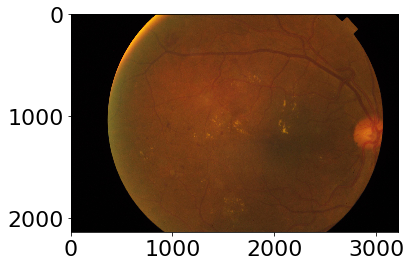

In [26]:
row = df_train[df_train["year"] == 2019].iloc[0]
show_img(row.filename, row.path)

### Past

(597, 896, 3)
10_left.png


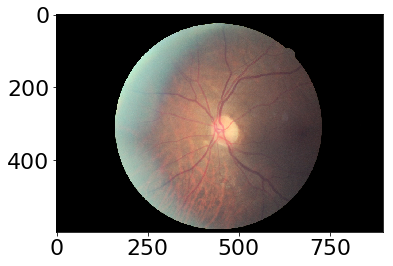

In [27]:
row = df_train[df_train["year"] == 2015].iloc[0]
show_img(row.filename, row.path)

## 9-Eyes

Visualize 9 images from a set at a time, to learn a bit more about the set at once.

In [28]:
def plot_first_9(df_to_plot):
    plt.figure(figsize=[30,30])
    for x in range(9):
        path = df_to_plot.iloc[x].path
        filename = df_to_plot.iloc[x].filename
        img = PIL.Image.open(f"{path}/{filename}")
        print(filename)
        plt.subplot(3, 3, x+1)
        plt.imshow(img)
        title_str = filename+", diagnosis: "+str(df_to_plot.iloc[x].diagnosis)
        plt.title(title_str)

In [29]:
from imgaug import augmenters as iaa

def img_augment(img):
    #fifty_chance = lambda aug: iaa.Sometimes(0.5, aug)
    import random
    if random.randint(1,101) > 90:
        #print("original")
        #one in 10 return original image
        return img
    seq = iaa.SomeOf(3, [
        iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        #iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 1.0 TODO: test for good values
        iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            scale=(0.8, 1.2),
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": 0}, # translate by -20 to +20 percent (per axis)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            rotate=(-10, 10), # rotate by -10 to +10 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            shear=(-5, 5), # shear by -5 to +5 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
    ])
    img = seq.augment_image(img)
    return img

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
#https://github.com/aleju/imgaug

In [30]:
from keras.applications import resnet50
import random

def img_pad_resize(df, filename, input_path, augment):
    img_meta = df[df["filename"] == filename].iloc[0]
    #print(img_meta)
    img = PIL.Image.open(f'{input_path}/{filename}')

    cropped = False
    if random.randint(1,101) > 50:
        aspect_ratio = img_meta["aspect_ratio"]
        if aspect_ratio > 2 or aspect_ratio < 0.5:
            img_w = img_meta["width"]
            img_h = img_meta["height"]
            diff = abs(img_w-img_h)
            if img_w > img_h:
                shorter = "height"
                larger = "width"
                crop_y = 0
                crop_x = random.randint(0, diff)
            else:
                shorter = "width"
                larger = "height"
                crop_x = 0
                crop_y = random.randint(0, diff)
            crop_size = img_meta[shorter]
            img_cropped = img.crop((crop_x, crop_y, crop_x+crop_size, crop_y+crop_size))
            img.close()
            img = img_cropped
            cropped = True
            #print("cropped:"+filename)
       
    w = img.size[0]
    h = img.size[1]
    pad_size = np.abs(h-w)
    wm = hm = 1
    pw = ph = 0
    if w < h:
        wm = h / w
        pw = pad_size / 2
    else:
        hm = w / h
        ph = pad_size / 2
    w *= wm
    h *= hm
    h = int(h)
    w = int(w)
    pw = int(pw)
    ph = int(ph)
    padding = (pw, ph, pw, ph)
    padded = ImageOps.expand(img, padding)
    resized = padded.resize((model_img_size, model_img_size))
    np_img = np.array(resized)
    img.close()
    padded.close()
    del img
    del padded
    if augment:
        np_img = img_augment(np_img)
    np_img = resnet50.preprocess_input(np_img)
    return np_img

In [31]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a.iloc[p], b[p]

In [32]:
from skimage.io import imread
from skimage.transform import resize
from keras.utils import Sequence

#https://github.com/sdcubber/Keras-Sequence-boilerplate/blob/master/Keras-Sequence.ipynb
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class MySequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, mode="train", augment=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.mode = mode
        self.max_idx = math.ceil(len(x_set)/batch_size)
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx2 = idx % self.max_idx
        #i guess the len method above stops the generator from being called too much
        #print(f"idx:{idx}, idx2:{idx2}")
        start = idx * self.batch_size
        end = min(start + batch_size, len(self.x))
        batch_x = self.x.iloc[start : end]
        batch_y = self.y[start : end]
        
        next_batch = []
        for index, row in batch_x.iterrows():
            file_name = row["filename"]
            file_path = row["path"]
            padded = img_pad_resize(self.x, file_name, file_path, self.augment)
            if padded.shape != (model_img_size, model_img_size, 3):
                print(f"shape mismatch {file_name}, {file_path}, {padded.shape}")
                print()
                #the image has alpha channel, drop it
                padded = padded[ :, :, :3]
            
            next_batch.append(padded)
        np_y = np.array(batch_y)
        result = np.array(next_batch), np_y

        #print(result[0].shape)
        return result

    def on_epoch_end(self):
        self.x, self.y = unison_shuffled_copies(self.x, self.y)


In [33]:
df_train_2015.shape

(35126, 10)

In [34]:
y = df_train_2015["diagnosis"]


In [35]:
y = np.zeros((n_rows_2015, n_classes))
idx = 0
for diagnosis in df_train_2015["diagnosis"]:
    y[idx][int(diagnosis)] = 1
#    for label_idx in label_set:
#        y[idx][int(label_idx)] = 1
    idx += 1

In [36]:
y[:10]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [37]:
from sklearn.model_selection import train_test_split

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
indexes = np.arange(df_train_2015.shape[0])
train_indices, valid_indices = train_test_split(indexes, test_size=0.10, random_state=8, stratify=y)

In [38]:
train_sub_df = df_train_2015.iloc[train_indices]
train_sub_y = y[train_indices]
valid_sub_df = df_train_2015.iloc[valid_indices]
valid_sub_y = y[valid_indices]
#train_gen = MySequence(train_sub_df, train_sub_df["breed_label"], batch_size)
#valid_gen = MySequence(valid_sub_df, valid_sub_df["breed_label"], batch_size)
warmup_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=False)
#TODO: remove probability of no augment from generator?
train_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=True)
valid_gen = MySequence(valid_sub_df, valid_sub_y, batch_size, augment=False)

In [39]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
checkpoint = ModelCheckpoint('../working/Resnet50_best_{epoch:03d}_{val_loss:.2f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

callbacks_list = [checkpoint, csv_logger, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [40]:
def plot_gen_batch(idx):
    # configure batch size and retrieve one batch of images
    plt.clf() #clears matplotlib data and axes
    #for batch in train_generator:
    rows = (batch_size / 3)+1
    plt.figure(figsize=[30,10*rows])
    batch = train_gen.__getitem__(idx)
    for x in range(0,batch_size-1):
    #    print(train_generator.filenames[x])
        plt.subplot(rows, 3, x+1)
        plt.imshow(batch[0][x], interpolation='nearest')

        diagnosis = batch[1][x]
        print(diagnosis)

    plt.show()

[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]


<Figure size 432x288 with 0 Axes>

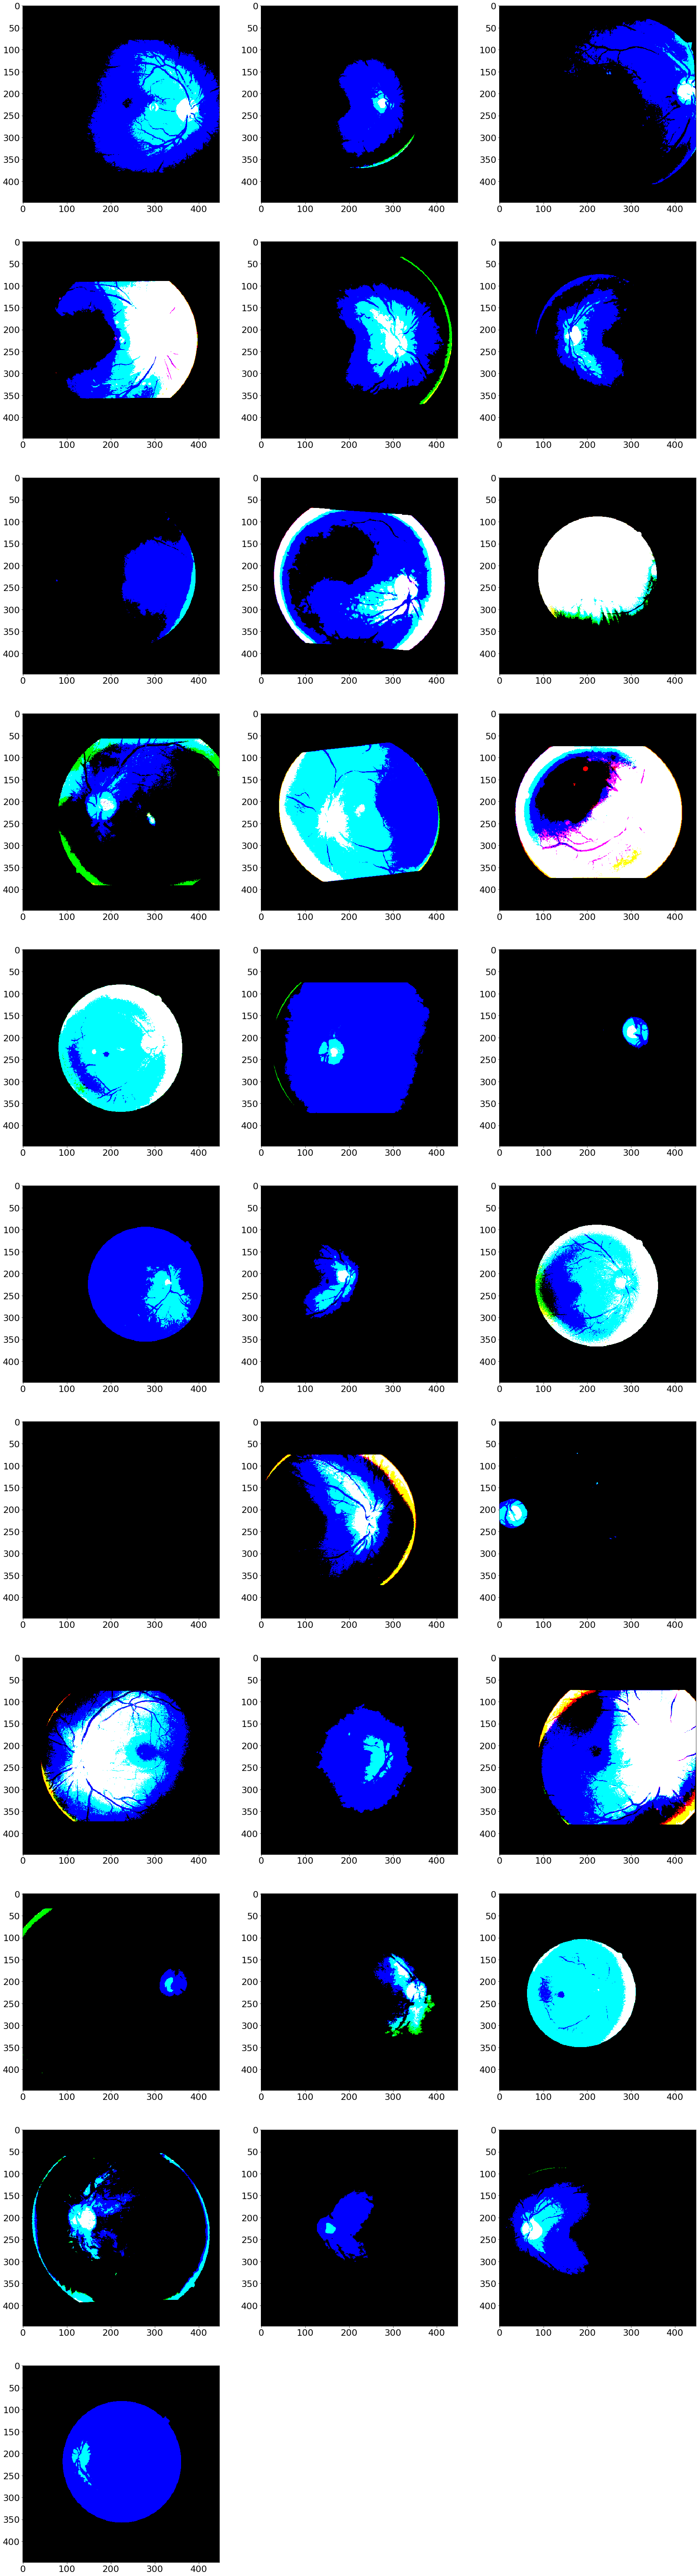

In [41]:
plot_gen_batch(0)

In [42]:
from keras_applications import imagenet_utils as utils

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    # backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    backend, layers, models, keras_utils = keras.backend, keras.layers, keras.models, keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = utils._obtain_input_shape(input_shape,
                                          default_size=224,
                                          min_size=32,
                                          data_format=backend.image_data_format(),
                                          require_flatten=include_top,
                                          weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x


def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)


In [44]:
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications.resnet50 import ResNet50

def create_model(trainable_layer_count):
    input_tensor = Input(shape=(model_img_size, model_img_size, 3))
    base_model = ResNet50V2(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    if load_weights:
        base_model.load_weights('../input/retinopathy_weights/resnet50_best.h5')

#    base_model = ResNet50(include_top=False,
#                          #the weights value can apparently also be a file path..
#                   weights=None, #loading weights from dataset, avoiding need for internet conn
#                   input_tensor=input_tensor)
#    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if trainable_layer_count == "all":
        for layer in base_model.layers:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layer_count:]:
            layer.trainable = True
    print("base model has {} layers".format(len(base_model.layers)))
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(base_model.output)
#     x = Flatten()(x)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
    x = Dropout(0.5)(x)
    #predict individual probability of each category
    final_output = Dense(n_classes, activation='softmax', name='final_output')(x)
#    final_output = Dense(n_classes, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)

    return model


In [45]:
model = create_model(train_depth)

base model has 190 layers


In [46]:
from keras.optimizers import Adam
#f2_score = my_f2

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss

In [47]:
#https://gombru.github.io/2018/05/23/cross_entropy_loss/


In [48]:
if warmup_enabled:
    #train_steps = 2*len(train_indices)/batch_size
    #valid_steps = 2*len(valid_indices)/batch_size
    train_steps = len(train_indices)/batch_size
    valid_steps = len(valid_indices)/batch_size
    fit_history = model.fit_generator(
            warmup_gen,
            steps_per_epoch=train_steps,
            epochs = 2,
            use_multiprocessing=True,
            workers=2,
            callbacks=[], #no callbacks for warmup
        verbose = 1
    )

Epoch 1/2
988/987 [==============================] - 1116s 1s/step - loss: 1.1250 - acc: 0.7319
Epoch 2/2
988/987 [==============================] - 1143s 1s/step - loss: 0.8946 - acc: 0.7348


In [49]:
from keras.optimizers import Adam
#f2_score = my_f2
#https://datascience.stackexchange.com/questions/26112/decay-parameter-in-keras-optimizers
if lr_decay > 0:
    model.compile(optimizer=Adam(lr=0.0001, decay=lr_decay), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss
else:
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss
    


In [50]:
#train_steps = 2*len(train_indices)/batch_size
#valid_steps = 2*len(valid_indices)/batch_size
train_steps = len(train_indices)/batch_size
valid_steps = len(valid_indices)/batch_size
fit_history = model.fit_generator(
        train_gen,
        steps_per_epoch=train_steps,
        epochs = epochs,
        validation_data=valid_gen,
        validation_steps=valid_steps,
        use_multiprocessing=True,
        workers=2,
        callbacks=callbacks_list,
    verbose = 1
)


Epoch 1/20
988/987 [==============================] - 1442s 1s/step - loss: 0.8738 - acc: 0.7348 - val_loss: 0.8650 - val_acc: 0.7347

Epoch 00001: val_loss improved from inf to 0.86503, saving model to ../working/Resnet50_best_001_0.87.h5
Epoch 2/20
988/987 [==============================] - 1406s 1s/step - loss: 0.8668 - acc: 0.7348 - val_loss: 0.8603 - val_acc: 0.7347

Epoch 00002: val_loss improved from 0.86503 to 0.86034, saving model to ../working/Resnet50_best_002_0.86.h5
Epoch 3/20
987/987 [============================>.] - ETA: 1s - loss: 0.8613 - acc: 0.7349
Epoch 00002: val_loss improved from 0.86503 to 0.86034, saving model to ../working/Resnet50_best_002_0.86.h5
988/987 [==============================] - 1418s 1s/step - loss: 0.8615 - acc: 0.7348 - val_loss: 0.8578 - val_acc: 0.7347

Epoch 00003: val_loss improved from 0.86034 to 0.85785, saving model to ../working/Resnet50_best_003_0.86.h5
Epoch 4/20
987/987 [============================>.] - ETA: 1s - loss: 0.8582 - acc:

In [51]:
def plot_loss_and_accuracy(fit_history):
    plt.clf()
    plt.plot(fit_history.history['acc'])
    plt.plot(fit_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    # summarize history for loss
    plt.plot(fit_history.history['loss'])
    plt.plot(fit_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


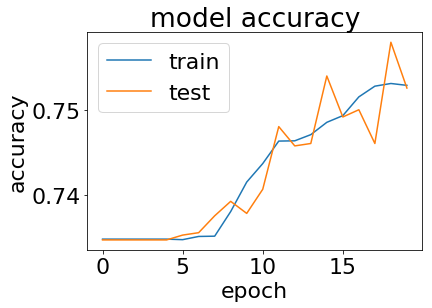

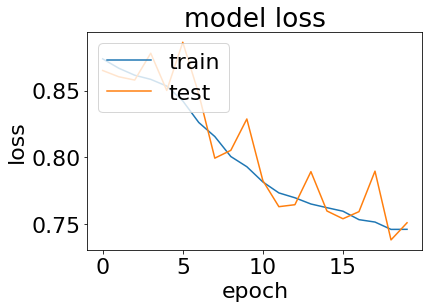

In [52]:
plot_loss_and_accuracy(fit_history)

In [53]:
pd.DataFrame(fit_history.history).head(20)

,val_loss,val_acc,loss,acc,lr
0,0.865029,0.734700,0.873780,0.734793,0.0001
1,0.860340,0.734700,0.866770,0.734793,0.0001
2,0.857846,0.734700,0.861475,0.734793,0.0001
3,0.877996,0.734700,0.858376,0.734793,0.0001
4,0.850045,0.734700,0.853323,0.734793,0.0001
5,0.886245,0.735269,0.842204,0.734729,0.0001
6,0.847413,0.735554,0.825969,0.735109,0.0001
7,0.799200,0.737546,0.815447,0.735141,0.0001
8,0.805077,0.739254,0.800422,0.738051,0.0001
9,0.828628,0.737831,0.792774,0.741530,0.0001


In [54]:
%%time

n_tta = 10

submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
predicted = []

for name in tqdm(submit['id_code']):
    np_img = img_pad_resize(df_test, name+".png", test_path, False)
#    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
#    img = PIL.Image.open(path+".png")
#    resized = img.resize((model_img_size, model_img_size))
#    np_img = np.array(resized)
    if tta:
        img_pred = np.zeros(n_classes)
        for x in range(n_tta):
            aug_img = img_augment(np_img)
            #img_augment already runs resnet50.preprocess_input
            score_predict = model.predict(aug_img[np.newaxis])
            img_pred += np.squeeze(score_predict)
        img_pred /= n_tta
        score_predict = img_pred
    else:
        score_predict = model.predict(resnet50.preprocess_input(np_img[np.newaxis]))
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))


CPU times: user 8min 24s, sys: 2min 26s, total: 10min 51s
Wall time: 9min 21s


In [55]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,4
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
